In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
print('Done')

Done


In [ ]:
import torch, torchvision
import numpy as np
import pandas as pd
import random
import json
import cv2
import os

import detectron2
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
setup_logger()

import itertools
from itertools import groupby
from google.colab.patches import cv2_imshow

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskutil
from pycocotools import mask as maskUtils

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [ ]:
# upload dataset to Google Drive and connect Drive to Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
register_coco_instances("HW", {}, "/content/gdrive/My Drive/HW3/dataset/pascal_train.json", "/content/gdrive/My Drive/HW3/dataset/train_images/train_images")
class_20_metadata = MetadataCatalog.get("HW")
dataset_dicts = DatasetCatalog.get("HW")

[12/07 21:43:54 d2.data.datasets.coco]: Loaded 1349 images in COCO format from /content/gdrive/My Drive/HW3/dataset/pascal_train.json


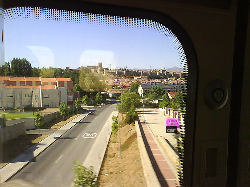

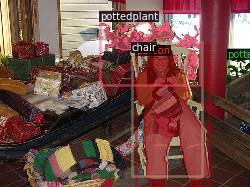

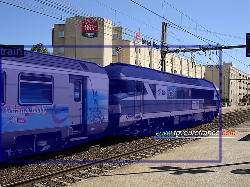

In [ ]:
import random

# show some image with mask
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=class_20_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
   
    #cv2_imshow(str(d["file_name"]), vis.get_image()[:, :, ::-1])
    cv2_imshow(vis.get_image()[:, :, ::-1])
    #cv2.waitKey()
    #cv2.destroyAllWindows()

In [ ]:
# Pretrained model implementation and its setting 
cfg = get_cfg()
cfg.merge_from_file("/content/gdrive/My Drive/HW3/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("HW3_20",)
cfg.DATASETS.TEST = ()   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "X-101-32x8d.pkl"   #initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00015
cfg.SOLVER.MAX_ITER = 150000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20  # 20 classes 

In [ ]:
# Training and save the cfg(weight)
import os
os.makedirs('/content/gdrive/My Drive/HW3/cfg.OUTPUT_DIR', exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
##Testing 
register_coco_instances("test", {}, "/content/gdrive/My Drive/HW3/dataset/test.json", "/content/gdrive/My Drive/HW3/dataset/test_images/test_images") # test dataset path
class_20_metadata = MetadataCatalog.get("HW3_20")
dataset_dicts = DatasetCatalog.get("test")


In [ ]:
# Load weight 
cfg.MODEL.WEIGHTS = ("/content/gdrive/My Drive/HW3/cfg.OUTPUT_DIR/model_0149999.pth") # trained weight path
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold 
cfg.DATASETS.TEST = ("test", )
predictor = DefaultPredictor(cfg)

In [ ]:
# Testing
anno = []
for d in dataset_dicts:
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    instances = outputs['instances']

    for i in range(len(instances.pred_classes)):
        instances.pred_masks_rle = [mask_util.encode(np.asfortranarray(mask)) for mask in instances.pred_masks.detach().cpu().numpy()]
        for rle in instances.pred_masks_rle:
            rle['counts'] = rle['counts'].decode('utf-8')
        code = instances.pred_masks_rle
        predict = {'image_id': d['image_id'], 'category_id': instances.pred_classes[i].item() + 1,
                   'score': instances.scores[i].item(), 'segmentation': code[i]}
        anno.append(predict)

# Produce json file
with open('/content/gdrive/My Drive/HW3/sub.json', 'w') as f:
    json.dump(anno, f)